In [2]:
import itertools
import math 
import os

from tifffile import imsave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import xml.etree.ElementTree as ET

from matplotlib.path import Path
from PIL import Image
from sklearn.model_selection import train_test_split

import sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import lidc_helpers

# Inspect DICOM Images

Below is an example of loading a standard dicom image file with pydicom. Note: 
1. Loading an image with pydicom: $\texttt{ds = pydicom.dcmread(path)}$
2. Image unique identifier: the unique image identifer in the DICOM header (0008, 0018)
3. The actual image data: ds.pixel_array

In [ ]:
# ds = pydicom.dcmread('raw_data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000001.dcm')
ds = pydicom.dcmread('raw_data/LIDC-IDRI/LIDC-IDRI-0004/01-01-2000-91780/3000534-58228/000001.dcm')

print(ds)

plt.imshow(ds.pixel_array, vmin=0, vmax=2048, cmap='gray') 
plt.show()

# Find the Path to CT Images 
Given a patient ID, the code below returns the path to the directory containing their CT images

In [ ]:
ct_path = lidc_helpers.find_ct_path('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0002')


# Find the UID of Images 

The code below creates a pandas DataFrame of UIDs for all CT images for a given patient

In [ ]:
df_path = lidc_helpers.get_uids_df(ct_path)
df_path.head()

# Get Image ROIS 

The contours for the "regions of interest" for tumors are included in the XML file within the image sequence directory. The code below extracts all contours available for a patient and stores them in a dictionary. 
- Keys: UIDs (same as the image path dictionary above)
- Values: 4 lists of tuples (x,y) of points included in the tumor boundary

*Note:* some of the data also included points that were explicity marked as *not* part of nodules, but could typically be confused as such. For our purposes, we ignored this data. 

In [ ]:
df_rois = lidc_helpers.get_rois_df(ct_path)
df_rois

# Create Summarizing DataFrame

In [ ]:
df_patient = lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0004')
df_patient

# Get Masks

In [ ]:
imgs = list(lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0004')['path'])
rois = list(lidc_helpers.get_patient_df_v2('raw_data/LIDC-IDRI/', 'LIDC-IDRI-0004')['ROIs'])


img1 = pydicom.dcmread(imgs[0]).pixel_array
mask1 = lidc_helpers.get_mask(img1, rois[0])

fig, axs = plt.subplots(2, 4, figsize=(18, 6))

for i in range(4):
    img = pydicom.dcmread(imgs[i]).pixel_array
    mask = lidc_helpers.get_mask(img1, rois[i])
    axs[0][i].imshow(img, vmin=0, vmax=2048, cmap='gray')
    axs[1][i].imshow(mask, cmap='gray')
plt.show()

In [ ]:
img1[0]

In [3]:
from lidc_helpers import *
from data_downloader import interpolate_and_normalize

In [4]:
pid_df = lidc_helpers.get_patient_df_v2('../data/raw/LIDC-IDRI/', 'LIDC-IDRI-0020')

image = [pydicom.dcmread(row[1].path).pixel_array for row in pid_df.iterrows()]
rois = [row[1].ROIs for row in pid_df.iterrows()]
mask = [get_mask(im, roi) for im, roi in zip(image, rois)]

slice_thickness = pydicom.dcmread(pid_df.iloc[0].path)[('0018', '0050')].value
pixel_spacing = pydicom.dcmread(pid_df.iloc[0].path)[('0028', '0030')].value


image = interpolate_and_normalize(np.array(image), slice_thickness, pixel_spacing)
mask = interpolate_and_normalize(np.array(mask), slice_thickness, pixel_spacing, norm=False)
mask[mask > .5] = 1
mask[mask <= .5] = 0

1.25188196

In [5]:
image.shape

(8, 256, 256)

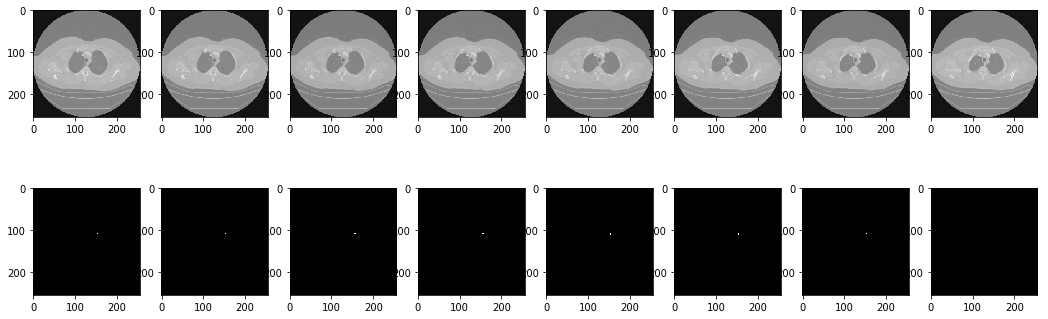

In [7]:
fig, axs = plt.subplots(2, 8, figsize=(18, 6))

for i in range(8):
    axs[0][i].imshow(image[i], cmap='gray')
    axs[1][i].imshow(mask[i], cmap='gray')
plt.show()